## Margin Recommender by Clustering

In this notebook we will try to predict recommended margin range for when a customer wants to by a new product by using unsupervised learning. 
More specifically we will first cluster products and then customers. After the clustering is performed we can calcuate the upper and lower bound for recommended margin with the following formula: 



We start off by importing the necessary libraries, and reading in the data.

In [833]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.decomposition import PCA

filepath = 'ECOMMRecords2020.csv'
data = pd.read_csv(filepath)
data_original = data.copy()


### Helper Functions
This section contains a variety of important functions used throughout the project. 

In [834]:
def get_coefficient_variation(data, feature): 
    '''
    The function calculates the coefficient of variation (CV) of the "Margin" for each category in the specified feature.

    Returns a sorted DataFrame with the mean, standard deviation, and CV for each category.
    '''

    grouped_data = data.groupby(feature)
    mean, std = grouped_data["Margin"].mean(), grouped_data["Margin"].std()
    df = pd.concat([mean, std], axis = 1).reset_index()
    df.columns = [feature, "Mean", "Std"]
    df["CoefficientOfVariation"] = (df["Std"]/df["Mean"])**2

    return df.sort_values(by = "CoefficientOfVariation")


In [835]:


def split_data(feature, data):
    '''
    Splits a DataFrame into multiple DataFrames based on the unique values of a specified categorical feature.

    Parameters:
    - feature: The column name to split the DataFrame by.
    - data: The DataFrame to split.

    Returns:
    - A dictionary where keys are unique feature values and values are the corresponding DataFrames.
    '''

    categories = list(data[feature].unique())
    dataframes = {}

    for c in categories: 
        df = data[data[feature] == c]
        df = df.set_index("RowID")
        dataframes[c] = df
        
    return dataframes


In [836]:
from datetime import datetime

'''
This cell contains all functions that are used to create new features used by the KMeans
algorithms to group products in clusters. 
More functions are needed to create more features to achieve better clustering results. 
'''

def add_average_margin_feature(dataframe):
    means = dataframe.groupby("ProductName")["Margin"].mean().reset_index()
    means.columns = ["ProductName", "MeanMargin"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 
    

def add_average_cost_per_unit_feature(dataframe):
    dataframe.loc[:, "CostPerUnit"] = dataframe["Cost"]/dataframe["Quantity"]
    means = dataframe.groupby("ProductName")["CostPerUnit"].mean().reset_index()
    means.columns = ["ProductName", "MeanCostPerUnit"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 

def add_average_sales_in_past_per_product(n_months, dataframe):
    dataframe["OrderDate"] = pd.to_datetime(dataframe["OrderDate"])
    last_date = dataframe["OrderDate"].max()
    n_months_ago = last_date - pd.DateOffset(months = n_months)
    filtered_data = dataframe[dataframe["OrderDate"] >= n_months_ago]
    meanSales = filtered_data.groupby("ProductName")["Sales"].mean().reset_index()
    meanSales.columns = ["ProductName", "AverageSalesPastMonths"]
    new_df = pd.merge(meanSales, dataframe, on = "ProductName")
    return new_df

def number_of_orders_per_product(dataframe): 
    product_order_counts = dataframe.groupby("ProductID")["OrderID"].count().reset_index()
    product_order_counts = product_order_counts.rename(columns = {"OrderID" : "NumberOfOrders"})
    dataframe = dataframe.merge(product_order_counts, on = "ProductID", how = "left")
    return dataframe
    
def add_total_sales_for_product(dataframe): 
    product_sales = data.groupby("ProductID")["Sales"].sum().reset_index()
    product_sales.columns = ["ProductID", "TotalSales"]
    new_df = pd.merge(dataframe, product_sales, on = "ProductID", how = "left")
    return new_df

def add_total_cost_for_product(dataframe): 
    product_cost = data.groupby("ProductID")["Cost"].sum().reset_index()
    product_cost.columns = ["ProductID", "TotalCost"]
    new_df = pd.merge(dataframe, product_cost, on = "ProductID", how = "left")
    return new_df

    

# Group products based on sales. Use the TotalRevenue. 
# Start by picking two features and see if there is any clustering. For example revenue and avg margin, or margin and number of orders. 
# Do not use average but sum. Also try changing the scaling method. 

In [837]:
def feature_engineering_preprocessing(dataframes : dict, scaler) -> dict: 
    '''
    The function applies multiple feature engineerings steps to each dataframe in the input dictionary. 

    It then returns a dictionary with the engineered dataframes. 
    '''

    result = {}

    for category in dataframes.keys(): 
        df = dataframes[category].copy()
        
        df = number_of_orders_per_product(df)
        df = add_total_sales_for_product(df)
        df = add_total_cost_for_product(df)
        df = add_average_margin_feature(df)

        original_index = df.index
        
        features = ["TotalCost", "TotalSales", "NumberOfOrders", "MeanMargin"]
        df = scaler.fit_transform(df[features])
        df = pd.DataFrame(data = df, columns = scaler.get_feature_names_out(), index = original_index)
        result[category] = df
        
    
    return result


In [838]:
def find_optimal_k(dataframes : dict): 
    '''
    Identifies the optimal number of clusters for KMeans using the elbow method and plotting the silhouette score. 

    Returns a plot of the interia score and silhouette score versus number of clusters for each of the dataframes 
    in the input dictionary. 
    '''
    ks = [x for x in range(2, 11)]
    inertia_scores = []
    silhouette_scores = []
    
    for category in dataframes.keys(): 
        data = dataframes[category]
        inertia = []
        silhouette = []
        for k in ks: 
            model = KMeans(n_clusters = k, random_state = 42, init = 'k-means++')
            predicted = model.fit_predict(data)
            inertia.append(model.inertia_)
            silhouette.append(silhouette_score(data, predicted))

        inertia_scores.append(inertia)
        silhouette_scores.append(silhouette)
    
    fig, ax = plt.subplots(nrows = len(dataframes.keys()), ncols = 2, figsize = (15, 14), squeeze=False)
    for i in range(len(dataframes.keys())): 
        ax[i, 0].plot(ks, inertia_scores[i])
        ax[i, 1].plot(ks, silhouette_scores[i])
        ax[i, 0].set_xlabel("Number of Clusters")
        ax[i, 0].set_ylabel("Inertia")
        ax[i, 1].set_xlabel("Number of Clusters")
        ax[i, 1].set_ylabel("Silhouette Score")
        fig.text(0.5, 0.95 - (i*0.3), f"{list(dataframes.keys())[i]}", ha = 'center', fontsize = 14, weight = "bold")

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [839]:
def visualize_clusters(model, data, title):
    '''
    The function visualizes clusters produced by a clustering model in 2D space, by 
    using t-SNE for dimensionality reduction. 

    Returns a 2D scatter plot of the data points colored by their predicted cluster labels. 
    '''
    embedding = TSNE(n_components=2,
        init="pca",
        max_iter=500,
        n_iter_without_progress=150,
        perplexity= 20,
        random_state=0)   

    data_2D = embedding.fit_transform(data)
    
    labels = model.labels_
    cmap = plt.get_cmap('tab10', model.n_clusters)

    unique_labels = set(labels)
    fig, ax = plt.subplots(figsize = (15, 10))

    for l in unique_labels: 
        cluster = data_2D[labels == l]
        ax.scatter(cluster[:, 0], cluster[:, 1], color = cmap(l), label = f"Cluster {l}")

    ax.legend()
    ax.set_title(title)
    plt.show()



In [840]:
def cluster_product_data(dataframes_scaled : dict, num_clusters : dict, vizualize = False): 
    '''
    For each dataframe in the dictionary that contains the scaled data, and the features that we proceed with we fit a KMeans
    model to each of the dataframes, with the number of clusters specified in the num_clusters dictionary. 
    '''
    for category in dataframes_scaled.keys(): 
        model = KMeans(n_clusters = num_clusters[category], init = "k-means++", random_state=42)
        predicted = model.fit_predict(dataframes_scaled[category])
        
        if vizualize: visualize_clusters(model, dataframes_scaled[category], category) 

        dataframes_scaled[category]["ProductCluster"] = predicted


### Product Clustering

First, we create two essential features for the project. One of these will be used later for feature engineering, while the other—margin—is the target feature that we aim to predict.

In [841]:
data["Cost"] = (data["Sales"] - data["Profit"])/data["Quantity"]
data["Margin"] = data["Profit"]/data["Sales"]

In [842]:

category = get_coefficient_variation(data, "Category") # We found that the it is best to split the data on category by looking at the coefficient of variation. 
sub_category = get_coefficient_variation(data, "SubCategory")

In [843]:
# Conduct feature engineering and then scales the data so its ready to be fed into the KMeans algorithm. 
scaler = MinMaxScaler()
grouped_dataframes = split_data("Category", data)
#grouped_dataframes = {"All" : data}
data = feature_engineering_preprocessing(grouped_dataframes, scaler)

In [844]:
data["Technology"].head()

,TotalCost,TotalSales,NumberOfOrders,MeanMargin
0,0.176025,0.145596,0.000000,0.880416
1,0.171262,0.029062,0.000000,0.797227
2,0.002843,0.001827,0.000000,0.755633
3,0.054758,0.014511,0.333333,0.769642
4,0.054758,0.014511,0.333333,0.769642


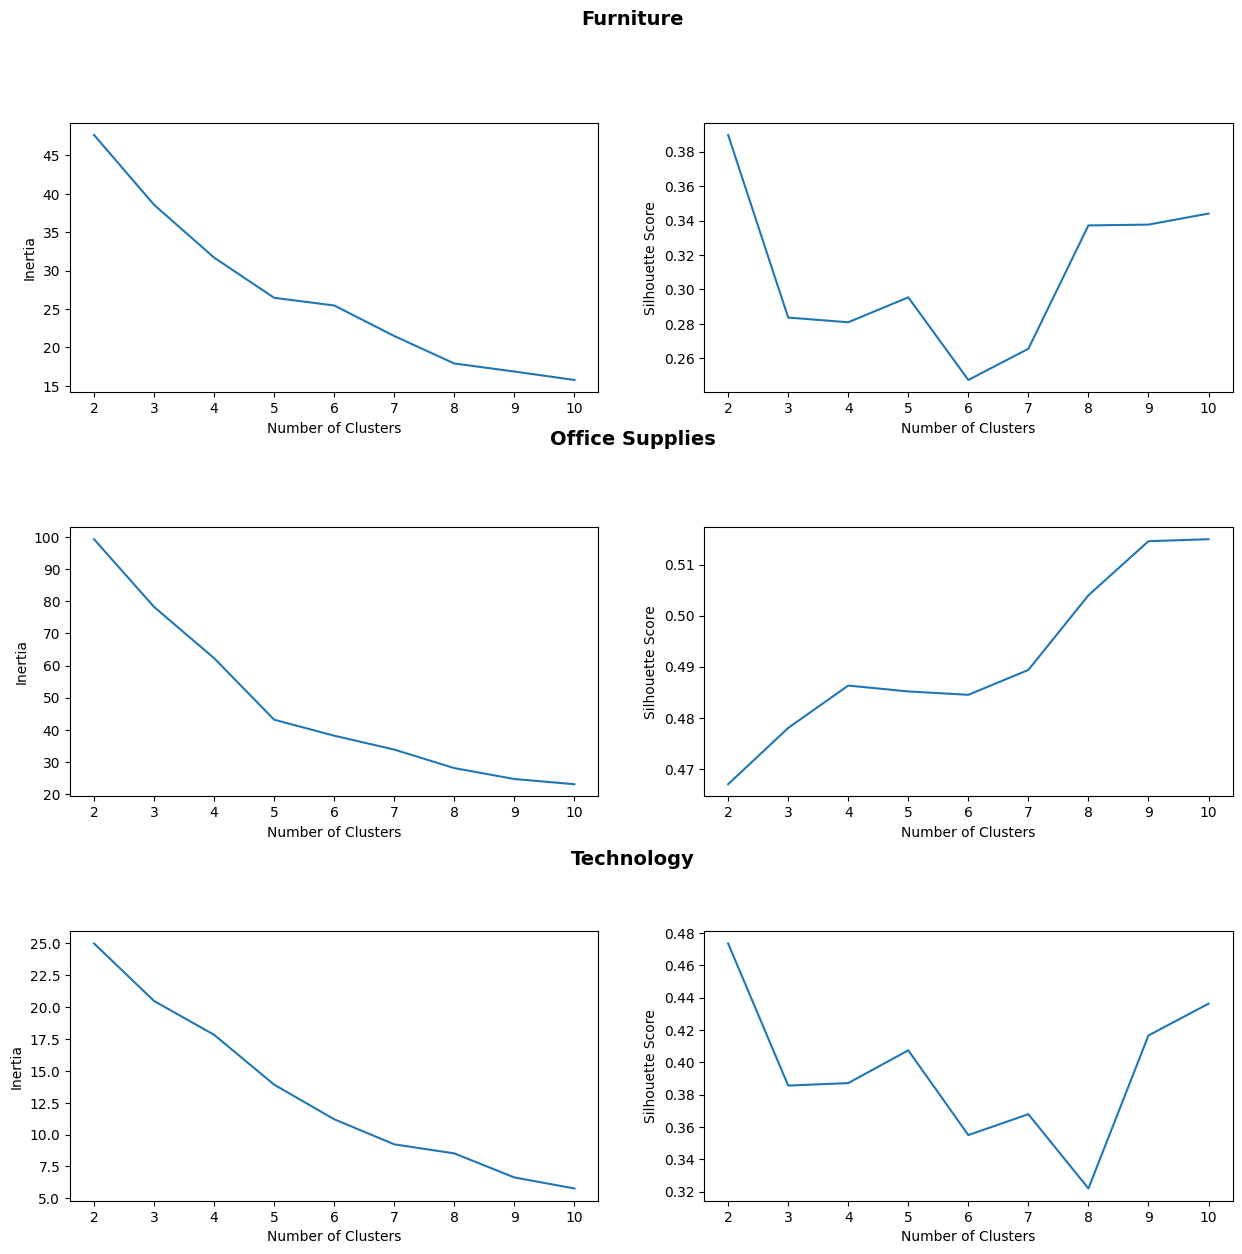

In [845]:
# Use the plots to identify which k is best to use for each category. 
find_optimal_k(data)

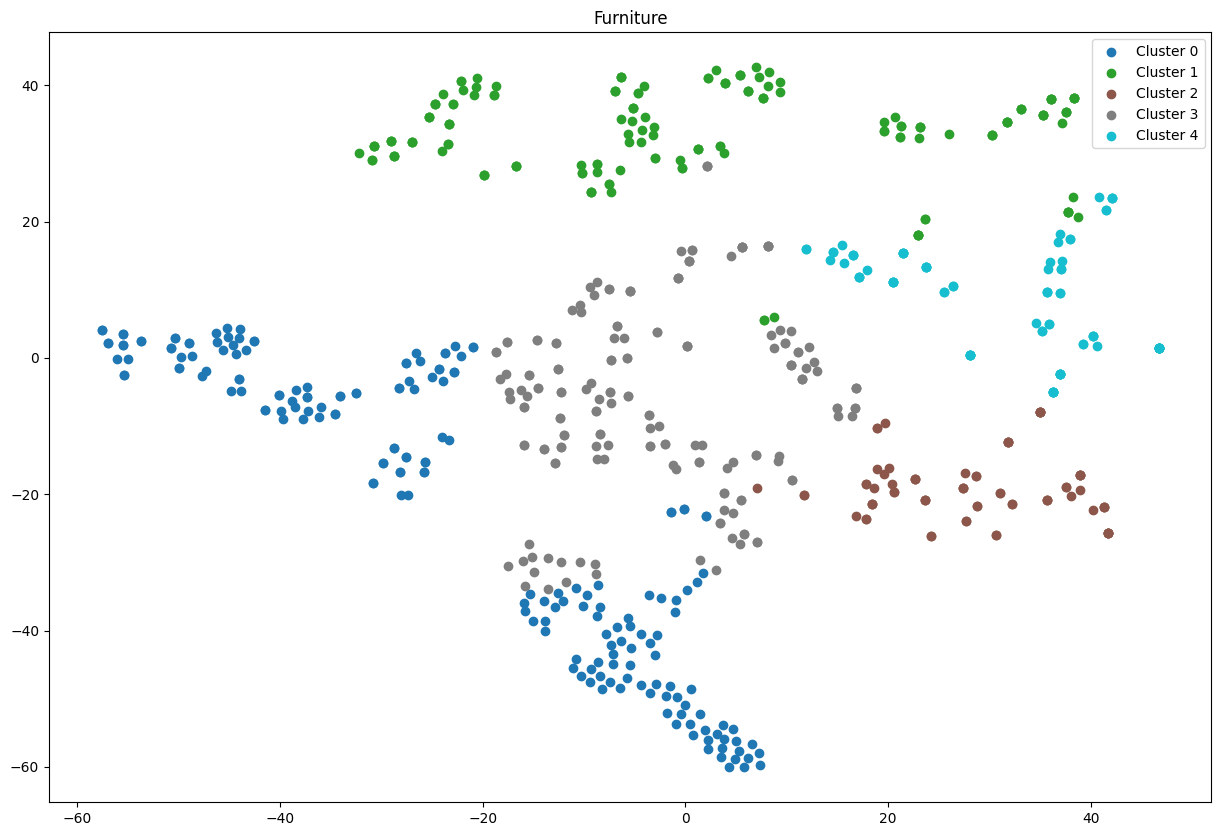

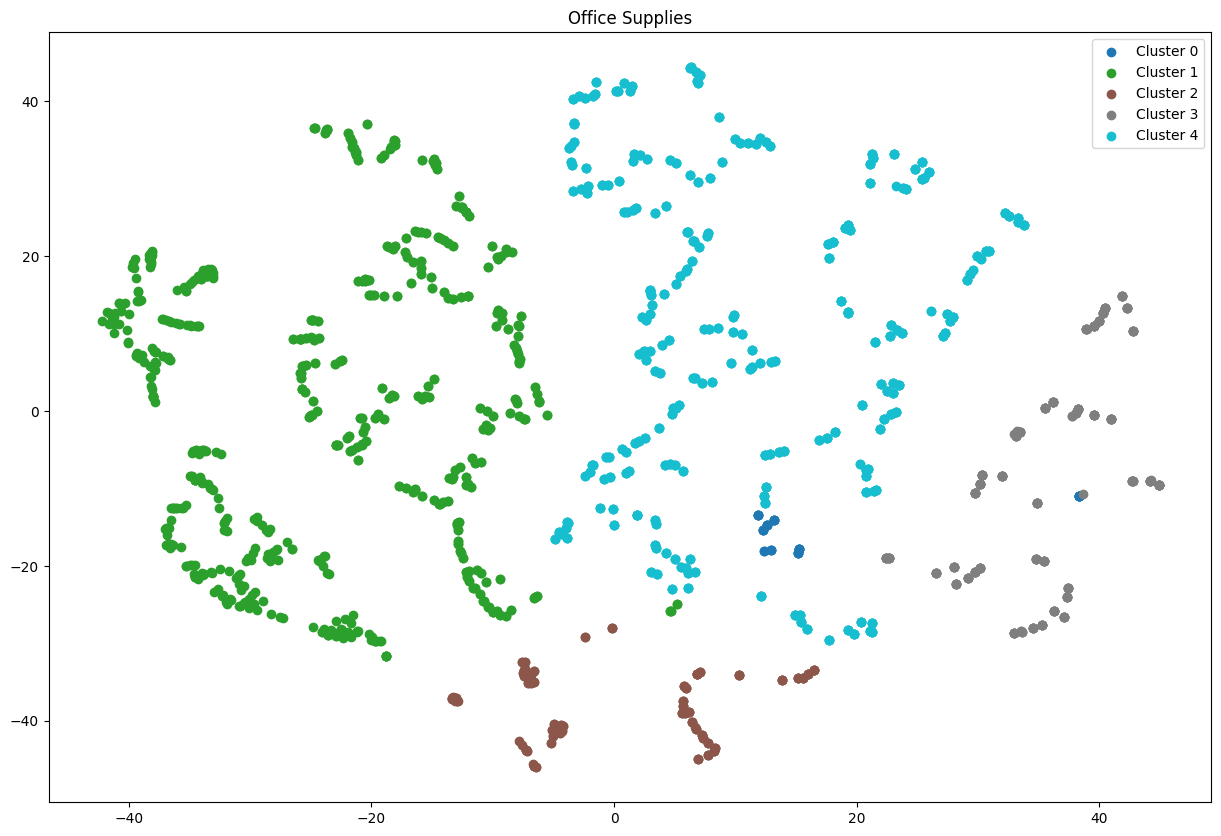

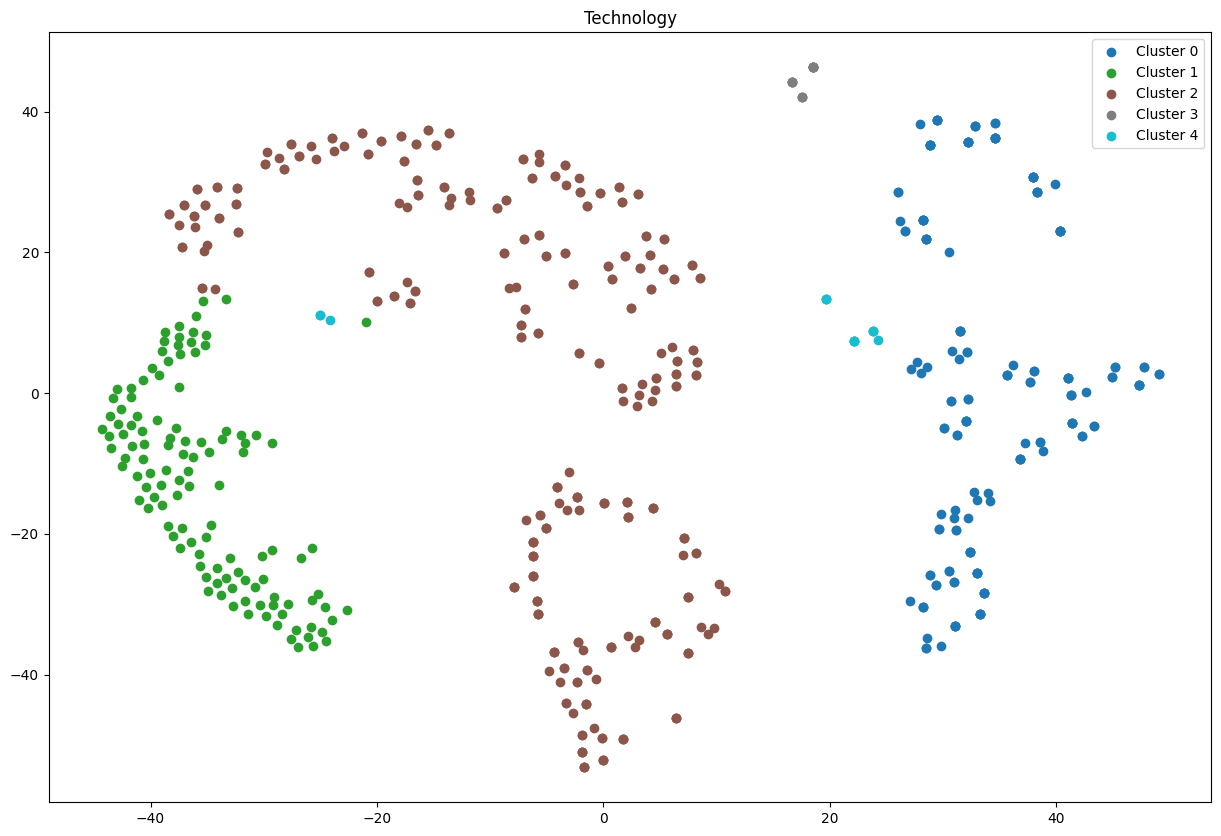

In [846]:
num_clusters = {"Technology" : 5, "Office Supplies" : 5, "Furniture" : 5}
#num_clusters = {"All" : 5}
cluster_product_data(data, num_clusters, vizualize=True)

### Customer Clustering

Compute revenue for costumer within each cluster. 

In [847]:
data["Technology"].head()

,TotalCost,TotalSales,NumberOfOrders,MeanMargin,ProductCluster
0,0.176025,0.145596,0.000000,0.880416,1
1,0.171262,0.029062,0.000000,0.797227,1
2,0.002843,0.001827,0.000000,0.755633,1
3,0.054758,0.014511,0.333333,0.769642,2
4,0.054758,0.014511,0.333333,0.769642,2


In [848]:
customer_data = {}

for category in data.keys(): 
    df_unscaled = scaler.inverse_transform(data[category].drop("ProductCluster"), axis = 1)
    df_unscaled = pd.DataFrame(data = df_unscaled, columns = scaler.get_feature_names_out())
    df_unscaled["ProductCluster"] = data[category]["ProductCluster"]
    

KeyError: "['ProductCluster'] not found in axis"

In [613]:

merged = {}
for category in dataframes_scaled.keys():
    dataframe_unscaled = scaler.inverse_transform(dataframes_scaled[category].drop("ProductCluster", axis = 1))
    dataframe_unscaled = pd.DataFrame(data = dataframe_unscaled, columns = scaler.get_feature_names_out())
    dataframe_unscaled["ProductCluster"] = dataframes_scaled[category]["ProductCluster"]
    dataframe_unscaled["RowID"] = data[category]["RowID"]
    merged[category] = pd.merge(dataframe_unscaled, grouped_dataframes[category], on = "RowID")

merged["Technology"].head()

KeyError: 'RowID'

In [455]:
new_features = ["MeanMargin", "NumberOfOrders", "TotalSales", "TotalCost", "TotalCost", "ProductCluster", "RowID", "ProductID", "CustomerID"]
test = merged["Technology"][new_features]
test.head()

,MeanMargin,NumberOfOrders,TotalSales,TotalCost,TotalCost,ProductCluster,RowID,ProductID,CustomerID
0,0.260000,1.0,5199.960,961.9926,961.9926,1,6341,TEC-MA-10001047,TS-21370
1,0.100000,1.0,1039.992,935.9928,935.9928,1,6364,TEC-MA-10002073,CK-12205
2,0.020000,1.0,67.800,16.6110,16.6110,1,9861,TEC-PH-10000169,HR-14770
3,0.046944,3.0,520.562,300.0081,300.0081,2,9444,TEC-PH-10000576,HR-14770
4,0.046944,3.0,520.562,300.0081,300.0081,2,2465,TEC-PH-10000576,CS-12460


In [456]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MeanMargin      624 non-null    float64
 1   NumberOfOrders  624 non-null    float64
 2   TotalSales      624 non-null    float64
 3   TotalCost       624 non-null    float64
 4   TotalCost       624 non-null    float64
 5   ProductCluster  624 non-null    int32  
 6   RowID           624 non-null    int64  
 7   ProductID       624 non-null    object 
 8   CustomerID      624 non-null    object 
dtypes: float64(5), int32(1), int64(1), object(2)
memory usage: 41.6+ KB


In [457]:
grouped = test.groupby(["CustomerID", "ProductCluster"])["TotalSales"].sum()
pivoted = grouped.unstack(fill_value = 0).reset_index(drop = True)
pivoted.index.name = None
pivoted.columns.name = None
pivoted.head()

scaler = MinMaxScaler()
scaled_customer_data = scaler.fit_transform(pivoted)
scaled_customer_data = pd.DataFrame(scaled_customer_data, columns=scaler.get_feature_names_out())

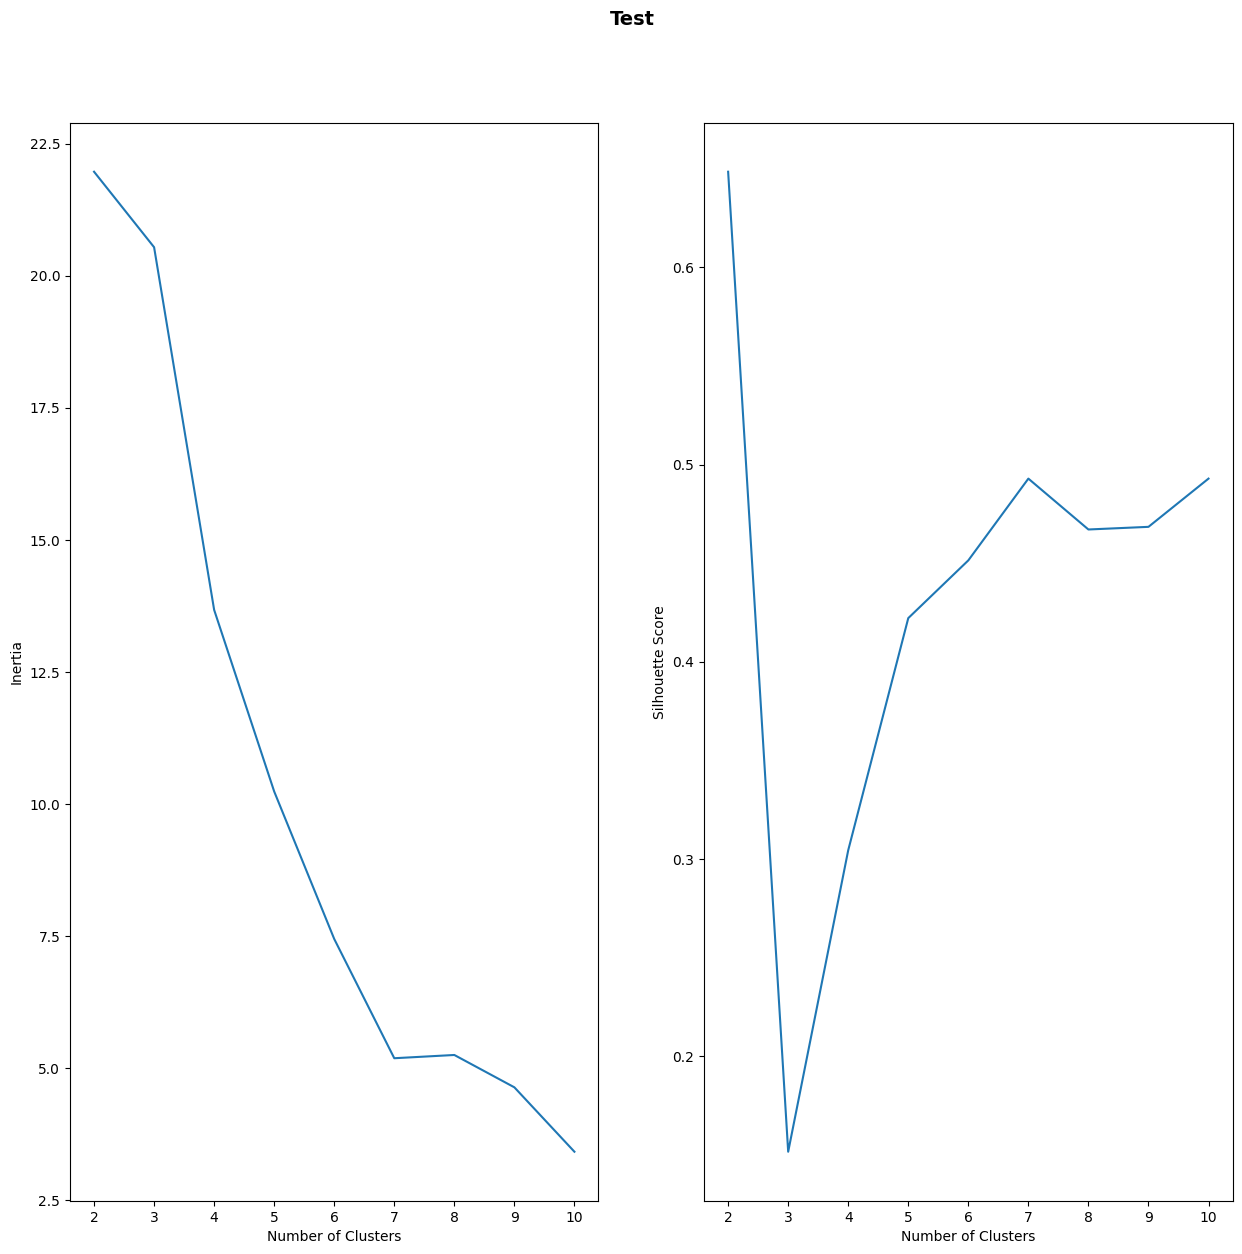

In [458]:
find_optimal_k({"Test" : scaled_customer_data})

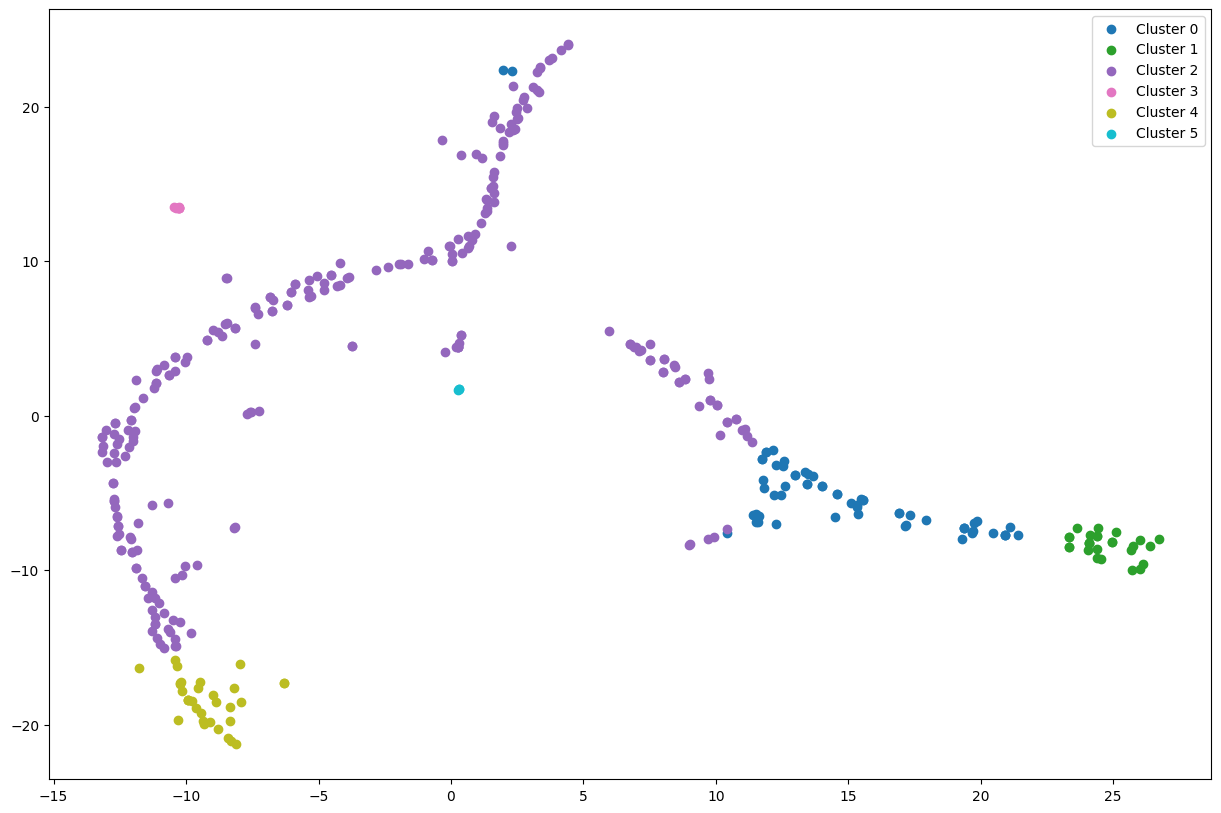

In [459]:
model = KMeans(n_clusters = 6, init = "k-means++", random_state=42)
model.fit(scaled_customer_data)
visualize_clusters(model, scaled_customer_data)

We calculate the customer percentile from their TotalRevenue and compare them to the total revenue for the customer in the same cluster. 

In [460]:
def calculate_customer_revenue_in_cluster(customerID, dataframe, cluster): 
    

IndentationError: expected an indented block (826643400.py, line 2)